In [2]:
from pathlib import Path
import yaml
import os

root_dir = Path("/media") / "sharedData" / "data"
root_name = "glass-a2744"

catalogue_dir = root_dir / "2024_08_16_A2744_v4" / "glass_niriss" / "match_catalogues"

grizli_home_dir = root_dir / "2024_08_16_A2744_v4" / "grizli_home"
grizli_extraction_dir = grizli_home_dir / "Extractions_v2"

In [3]:
from astropy.table import Table, join, Column, vstack
import numpy as np

cat_v1 = Table.read(catalogue_dir / "classification_v1" / "compiled_catalogue_v1.fits")

In [4]:
from itertools import product
from numpy.lib.recfunctions import structured_to_unstructured

filters = ["F115W","F150W","F200W"]
pas = ["72.0","341.0"]

beam_names = [f"{a},{b}" for b, a in product(pas, filters)]
coverage_names = [f"{b}_COVERAGE" for b in beam_names]
quality_names = [f"{b}_QUALITY" for b in beam_names]
new_names = [f"{b}_USE" for b in beam_names]

v2_cat = cat_v1.copy()

v2_cat.remove_columns(quality_names+new_names)

In [5]:
v2_out_dir = grizli_home_dir / "classification-stage-2"/"catalogues" / "compiled"
v2_out_dir.mkdir(exist_ok=True, parents=True)

new_cat_name = "internal_stage_3_1.fits"

In [6]:
from numpy.typing import ArrayLike

def table_to_array(table: Table) -> ArrayLike:
    """
    Convert an astropy table to a numpy array.

    Parameters
    ----------
    table : Table
        Original astropy table.

    Returns
    -------
    ArrayLike
        Numpy array.
    """
    return np.lib.recfunctions.structured_to_unstructured(table.as_array()) 

In [7]:
# v2_out_dir = grizli_home_dir / "classification-stage-2"/"catalogues" / "compiled"
# v2_out_dir.mkdir(exist_ok=True, parents=True)

prev_cat = Table.read(v2_out_dir / "internal_full_7.fits")

unified_cats = grizli_home_dir.glob(
    "classification-stage-2/catalogues/output/stage_3*.fits"
)

unified_list = []
for u_p in unified_cats:
    unified_list.append(Table.read(u_p))

unified_stack = vstack(unified_list)

# unified_stack

print(
    np.nansum(
        ~(
            (unified_stack["UNRELIABLE_REDSHIFT"])
            | (unified_stack["TENTATIVE_REDSHIFT"])
        )
    )
)

print(np.nansum(prev_cat["V1_CLASS"] == 0))

unified_stack["SECURE_REDSHIFT_UNIFIED"] = ~(unified_stack["UNRELIABLE_REDSHIFT"]|unified_stack["TENTATIVE_REDSHIFT"])
print (np.nansum(unified_stack["SECURE_REDSHIFT_UNIFIED"]),"uni")


unified_stack.rename_columns(
    ["SEG_ID", "UNRELIABLE_REDSHIFT", "TENTATIVE_REDSHIFT", "ESTIMATED_REDSHIFT", "COMMENTS"],
    ["NUMBER", "UNRELIABLE_REDSHIFT_UNIFIED", "TENTATIVE_REDSHIFT_UNIFIED", "ESTIMATED_REDSHIFT_UNIFIED", "COMMENTS_PJW"],
)

temp_cat = join(prev_cat, unified_stack, keys="NUMBER", join_type="left")
temp_cat["UNRELIABLE_REDSHIFT_UNIFIED"][temp_cat["UNRELIABLE_REDSHIFT_UNIFIED"].mask] = False
temp_cat["TENTATIVE_REDSHIFT_UNIFIED"][temp_cat["TENTATIVE_REDSHIFT_UNIFIED"].mask] = False
# temp_cat

# print(np.nansum(temp_cat["TENTATIVE_REDSHIFT_UNIFIED"]))
# print(
#     np.nansum(
#         (prev_cat["Z_FLAG_ALL"] == 6)
#         | (prev_cat["Z_FLAG_ALL"] == 7)
#         | (temp_cat["TENTATIVE_REDSHIFT_UNIFIED"])
#     )
# )

# print(
#     np.nansum(
#         (prev_cat["Z_FLAG_ALL"] == -2)
#         | (prev_cat["Z_FLAG_ALL"] == -1)
#         | (temp_cat["UNRELIABLE_REDSHIFT_UNIFIED"])
#     )
# )
# print ("secure", np.nansum(~(
#         (temp_cat["TENTATIVE_REDSHIFT_UNIFIED"]==True)
#         | (temp_cat["UNRELIABLE_REDSHIFT_UNIFIED"]==True))))

# print (np.nansum(temp_cat["COMMENTS_PJW"]))
# temp_cat["COMMENTS_PJW"][temp_cat["SECURE_REDSHIFT_UNIFIED"]]
prev_cat["COMMENTS_PJW"] = temp_cat["COMMENTS_PJW"]


90
511
90 uni


In [11]:

# Detected, not extracted
prev_cat["Z_FLAG_V3"] = np.full(len(prev_cat), np.nan)#, dtype=int)
prev_cat["Z_FLAG_V3"][(prev_cat["V1_CLASS"] ==0)] = 0
# Detected, rejected in stage 1
prev_cat["Z_FLAG_V3"][(prev_cat["V1_CLASS"] <= 3) & (prev_cat["V1_CLASS"] != 0)] = 1
# print ("1 in v3", np.nansum(prev_cat["Z_FLAG_V3"]==1))


# Undetermined redshift
prev_cat["Z_FLAG_V3"][
    (prev_cat["Z_FLAG_ALL"] == -10)
    | (prev_cat["Z_FLAG_ALL"] == -2)
    | (prev_cat["Z_FLAG_ALL"] == -1)
    | (prev_cat["Z_FLAG_ALL"] == 0)
    | (temp_cat["UNRELIABLE_REDSHIFT_UNIFIED"]==True)
] = 2
# print ("2 in v3", np.nansum(prev_cat["Z_FLAG_V3"]==2))

# Tentative
prev_cat["Z_FLAG_V3"][
    ((prev_cat["Z_FLAG_ALL"] == 6) | (prev_cat["Z_FLAG_ALL"] == 7))
    | (temp_cat["TENTATIVE_REDSHIFT_UNIFIED"]==True)
] = 3
# print ("3 in v3", np.nansum(prev_cat["Z_FLAG_V3"]==3))
# print ("2 in v3", np.nansum(prev_cat["Z_FLAG_V3"]==2))

# Secure
prev_cat["Z_FLAG_V3"][
    # (~(
        (temp_cat["SECURE_REDSHIFT_UNIFIED"]==True)
        # | (temp_cat["UNRELIABLE_REDSHIFT_UNIFIED"]==True)
    # ))
    | ((prev_cat["Z_FLAG_ALL"] == 9) | (prev_cat["Z_FLAG_ALL"] == 10))
] = 4
# print (len(prev_cat))
# print (np.nansum(prev_cat["V1_CLASS"]<=3)-np.nansum(prev_cat["V1_CLASS"]==0))
# print (np.nansum(prev_cat["Z_FLAG_ALL"]<=-20))
# print (np.nansum(prev_cat["Z_FLAG_ALL"]>=-10))

print(np.unique(np.array(prev_cat["Z_FLAG_V3"]), return_counts=True))
print (np.nansum(((prev_cat["Z_FLAG_ALL"] == -99)) & (prev_cat["Z_FLAG_V3"]==np.nan)))
# print (np.nansum(prev_cat["Z_FLAG_ALL"].mask))
total = 0
for u in np.unique(prev_cat["Z_FLAG_ALL"]):
    total += np.nansum(prev_cat["Z_FLAG_ALL"]==u)
    print (u, np.nansum(((prev_cat["Z_FLAG_ALL"] == u)) & (~np.isfinite(prev_cat["Z_FLAG_V3"]))))
print (total)

prev_cat["Z_EST_V3"] = prev_cat["Z_EST_ALL"]
prev_cat["Z_EST_V3"][temp_cat["SECURE_REDSHIFT_UNIFIED"]==True] = temp_cat["ESTIMATED_REDSHIFT_UNIFIED"][temp_cat["SECURE_REDSHIFT_UNIFIED"]==True]
prev_cat["Z_EST_V3"][temp_cat["TENTATIVE_REDSHIFT_UNIFIED"]==True] = temp_cat["ESTIMATED_REDSHIFT_UNIFIED"][temp_cat["TENTATIVE_REDSHIFT_UNIFIED"]==True]

prev_cat["Z_EST_V3"][prev_cat["Z_FLAG_V3"]<3] = np.nan

(array([0., 1., 2., 3., 4.]), array([ 511,  942, 1433,  116,  491]))
0
-99 0
-10 0
-2 0
-1 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
3493


In [ ]:
merged_cat = Table.read(v2_out_dir / "merged_z_cat_4.fits")
merged_cat = merged_cat["NUMBER","z_alt","z_nirspec","z_ground"]
merged_cat = merged_cat[merged_cat["NUMBER"].mask==False]
prev_cat.write(v2_out_dir / "internal_stage_3_2.fits", overwrite=True)
try:
    prev_cat.remove_columns(["z_alt","z_nirspec"])
except:
    pass
prev_cat = join(prev_cat, merged_cat, keys="NUMBER")

prev_cat.write(v2_out_dir / "internal_stage_3_1.fits", overwrite=True)

In [17]:
comment_colnames = [c for c in prev_cat.colnames if "COMMENTS" in c][1:]
print ([c for c in prev_cat.colnames if "Z_FLAG" in c][1:])
print (comment_colnames)
comment_list = []
for i, row in enumerate(prev_cat[:]):
    # row_arr = np.array([*row[comment_colnames].values()])
    if not np.array([*prev_cat.mask[i][comment_colnames]]).all():
        # print (np.array([*prev_cat.mask[i][comment_colnames]]))
    # print (np.isfinite(row_arr.astype(float)))
    # print (np.array([*row[comment_colnames].values()]))
        use_cols = [c for c in comment_colnames if prev_cat.mask[i][c]==False]
        # print (use_cols)
        comment_list.append(row["NUMBER"])
        print (row["NUMBER"],"\t",f"{row["Z_EST_V3"]:.3f}","\t", row["Z_FLAG_V3"],"\t",row["Z_FLAGS"],"\t",[*row[use_cols].values()],"\n")

print (np.array(comment_list))
for i in comment_list:
    print (i)

['Z_FLAG_Guido', 'Z_FLAG_Matt', 'Z_FLAG_Nicolo', 'Z_FLAG_Peter', 'Z_FLAG_Sofia', 'Z_FLAG_Tommaso', 'Z_FLAG_Xianlong', 'Z_FLAG_Yechi', 'Z_FLAGS', 'Z_FLAG_ALL', 'Z_FLAG_V3']
['COMMENTS_Benedetta', 'COMMENTS_Guido', 'COMMENTS_Matt', 'COMMENTS_Nicolo', 'COMMENTS_Peter', 'COMMENTS_Sofia', 'COMMENTS_Tommaso', 'COMMENTS_Xianlong', 'COMMENTS_Yechi', 'COMMENTS_PJW']
2 	 0.538 	 4.0 	 [b'2' -- -- b'2' b'2' -- -- -- --] 	 ['72 unusable\n'] 

10 	 nan 	 2.0 	 [-- -- -- -- -- b'0' b'0' -- --] 	 ['I do not see a source in the imaging and the spectrum has mostly absorption. Unsure of the nature of this source.\n', 'Unsure if this is a real source. No clear break.\n'] 

41 	 nan 	 2.0 	 [b'2' -- -- -- -- -- -- b'0' --] 	 ['too extend to constraint\n\n'] 

42 	 nan 	 2.0 	 [b'2' -- -- -- -- -- -- b'1' --] 	 ['not sure if the feature for z is attribute to contamination\n'] 

55 	 nan 	 2.0 	 [b'2' -- -- b'2' -- -- -- b'0' --] 	 ['too extended to be contaminated\n'] 

69 	 nan 	 2.0 	 [b'2' -- -- b'2' --

88
NUMBER  NPIX  XMIN XMAX YMIN ...  z_alt   z_nirspec z_ground      Z_EST_V3     
        pix2                 ...                                               
------ ------ ---- ---- ---- ... -------- --------- -------- ------------------
   659 1774.0 2144 2196 1875 ... 3.048054        --       --  3.020602619600849
  1129 3648.0 1789 1858 2464 ... 2.675606        --       -- 1.7892519580171218
  2535  432.0 1746 1767 4251 ... 5.769101        --       --  5.625695046557107
  2542 1558.0 4606 4652 4258 ... 3.054019  3.056035       --              3.015
NUMBER   NPIX  XMIN XMAX YMIN ...  z_alt   z_nirspec z_ground      Z_EST_V3     
         pix2                 ...                                               
------ ------- ---- ---- ---- ... -------- --------- -------- ------------------
   659  1774.0 2144 2196 1875 ... 3.048054        --       --  3.020602619600849
  2542  1558.0 4606 4652 4258 ... 3.054019  3.056035       --              3.015
  2926 13385.0 4259 4488 4669 ..

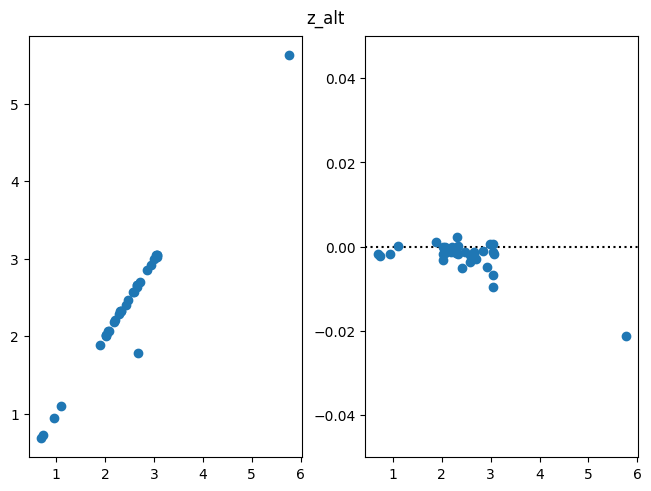

144
NUMBER  NPIX  XMIN XMAX YMIN ...  z_alt   z_nirspec z_ground       Z_EST_V3     
        pix2                 ...                                                
------ ------ ---- ---- ---- ... -------- --------- -------- -------------------
    21  483.0 4226 4262  560 ...       --    1.2698       --  1.2125249498664497
   104 2182.0 3946 3995  908 ...       --    0.2721   0.3047 0.30000000000000004
   996 4341.0 5116 5203 2307 ... 2.583214  2.590551       --                2.57
  1033  130.0 4899 4911 2341 ...       --  7.039813       --   7.161898328458023
  1407  691.0 5390 5424 2895 ...       --    3.1275   3.1291                3.15
  1511 2121.0 2248 2301 3055 ...       --      2.89       --    2.64493762674032
  1690  658.0 3960 3991 3263 ...       --  3.987356   3.9805                3.96
  1933 1745.0 2622 2681 3533 ...       --    2.3546       --  2.4250542261190615
  2514  254.0 3214 3233 4229 ...       --     7.882       --   8.055710330435605
  2542 1558.0 4606 4652 

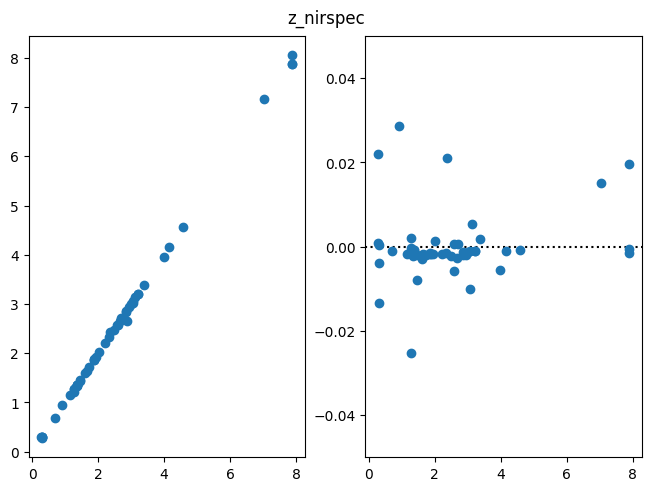

333
NUMBER   NPIX   XMIN XMAX YMIN ... z_alt z_nirspec z_ground       Z_EST_V3     
         pix2                  ...                                             
------ -------- ---- ---- ---- ... ----- --------- -------- -------------------
   295 177266.0 1315 1850 1277 ...    --        --   0.3031 0.36186306879239005
  1036   1392.0 5044 5089 2348 ...    --        --    0.546  0.5237335520921119
  1127   6087.0 3457 3557 2462 ...    --        --    0.304  0.2677019345163572
  1175  18702.0 4929 5106 2553 ...    --        --   0.3054  0.3338958297406403
  1403  16363.0 3498 3682 2887 ...    --        --   0.2975  0.2685887434641758
  1407    691.0 5390 5424 2895 ...    --    3.1275   3.1291                3.15
  1690    658.0 3960 3991 3263 ...    --  3.987356   3.9805                3.96
  2437  27701.0 5525 5710 4160 ...    --        --   0.4988  0.5622463535156079
NUMBER  NPIX  XMIN XMAX YMIN ... z_alt z_nirspec z_ground      Z_EST_V3     
        pix2                 ...       

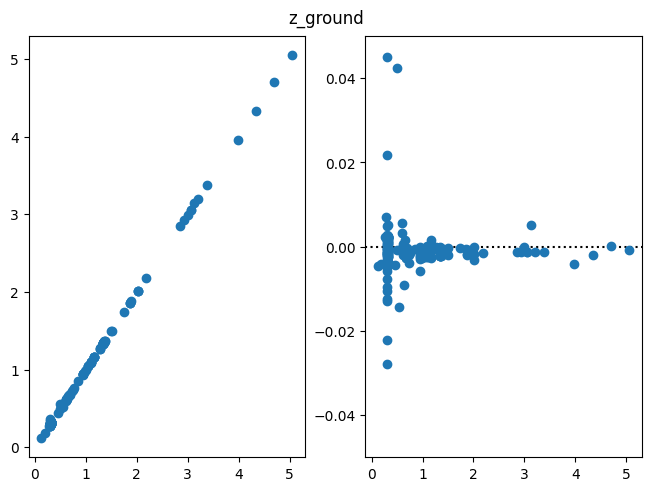

In [ ]:
undetermined = [
    867,
    1034,
]

secure = [
    55,
    721,
    1256 (2.685),
    1839 (~7.5),
    3009,   
    3013,
]
# separate = [
#     741,
#     1129
# ]
# rejoin = [
#     137,
#     180,
#     218,
#     838,
#     1185,
#     2081,
#     2084,
#     2111,
#     2172,
#     2182,
#     2233,
#     2242,
#     2781,
#     2876,
#     3218,
#     3310,
# ]

cluster = [
    171,
    225,
    228,
    277,
    281,
    295,
    328,
    384,
    455,
    680,
    718,
    789,
    850,
    1127,
    1135,
    1184,
    1203,
    1345,
    1690,
    1950,
    2028,
    2045,
    2437,
    2666,
]

In [ ]:

from matplotlib import pyplot as plt
# plt.scatter(
#     # prev_cat["Z_EST_V3"][temp_cat["SECURE_REDSHIFT_UNIFIED"]==True],
#     prev_cat["zphot"][temp_cat["SECURE_REDSHIFT_UNIFIED"]==True],
#     # temp_cat["ESTIMATED_REDSHIFT_UNIFIED"][temp_cat["SECURE_REDSHIFT_UNIFIED"]==True],
# )
# print (len(temp_cat["ESTIMATED_REDSHIFT_UNIFIED"][temp_cat["SECURE_REDSHIFT_UNIFIED"]==True]))

from matplotlib import pyplot as plt

for z_spec_name in ["z_alt","z_nirspec","z_ground"]:
    fig, axs = plt.subplots(1,2, constrained_layout=True)

    plot_idx = prev_cat["Z_FLAG_V3"] == 4
    # z_spec_name = "z_nirspec"

    print (np.nansum(~(prev_cat[z_spec_name].mask)))

    axs[0].scatter(
        # prev_cat["zphot"],
        prev_cat[z_spec_name][plot_idx],
        prev_cat["Z_EST_V3"][plot_idx],
        # temp_cat["ESTIMATED_REDSHIFT_UNIFIED"][temp_cat["SECURE_REDSHIFT_UNIFIED"]==True],
    )
    axs[1].scatter(
        prev_cat[z_spec_name][plot_idx],
        ((prev_cat["Z_EST_V3"]-prev_cat[z_spec_name])/(1+prev_cat[z_spec_name]))[plot_idx],
    )
    axs[1].axhline(0,c="k",linestyle=":",zorder=-1)

    print (prev_cat[(np.abs(prev_cat["Z_EST_V3"]-prev_cat[z_spec_name])>=0.02) & (plot_idx) & ~(prev_cat[z_spec_name].mask)])
    print (prev_cat[((prev_cat["Z_EST_V3"]-prev_cat[z_spec_name])<=0) & (plot_idx) & ~(prev_cat[z_spec_name].mask) & (prev_cat["Z_EST_V3"]>=3)& (prev_cat["Z_EST_V3"]<=4)])

    # axs[1].set_xlim(0.2,0.4)
    axs[1].set_ylim(-0.05,0.05)
    # print (len(temp_cat["ESTIMATED_REDSHIFT_UNIFIED"][temp_cat["SECURE_REDSHIFT_UNIFIED"]==True]))
    print (np.nansum(np.isfinite(prev_cat["Z_EST_V3"])))

    print (np.nansum(
        (plot_idx)
        & (prev_cat["z_ground"].mask)
        & (prev_cat["z_alt"].mask)
        & (prev_cat["z_nirspec"].mask)
    ))
    fig.suptitle(z_spec_name)

    plt.show()


In [10]:

# if not (v2_out_dir / new_cat_name / "test").is_file():
#     stage_2_cats = grizli_home_dir.glob(
#         "classification-stage-2/catalogues/output/stage_2*.fits"
#     )
#     p_names = []
#     hist_list = []

#     beam_quality_to_int = {"Unusable": 0, "Poor": 1, "Good": 2, "Excellent": 3}

#     for c in stage_2_cats:
#         p_cat = Table.read(c)
#         p_name = c.stem.split("_")[-1]
#         p_names.append(p_name)
#         print(p_name)
#         print (len(p_cat))
#         p_cat.sort("SEG_ID")

#         _, use_idxs,_ = np.intersect1d(np.array(v2_cat["SEG_ID"]), np.array(p_cat["SEG_ID"]), return_indices=True)

#         # print (use_idxs.shape,use_idxs.sum())

#         v2_cat["GRIZLI_REDSHIFT"][use_idxs] = p_cat["GRIZLI_REDSHIFT"]

#         for n in coverage_names:
#             v2_cat[n][use_idxs] = p_cat[n]

#         for n in quality_names:
#             v2_cat[f"{n}_{p_name}"] = np.nan
#             v2_cat[f"{n}_{p_name}"][use_idxs] = [beam_quality_to_int[k] for k in p_cat[n]]

#         comment_col = Column(name=f"COMMENTS_{p_name}", dtype=p_cat["COMMENTS"].dtype, length=len(v2_cat))
#         comment_col[use_idxs] = p_cat["COMMENTS"]
#         v2_cat.add_column(comment_col)

#         v2_cat[f"ESTIMATED_REDSHIFT_{p_name}"] = np.nan
#         v2_cat[f"ESTIMATED_REDSHIFT_{p_name}"][use_idxs] = p_cat["ESTIMATED_REDSHIFT"]

#         v2_cat[f"Z_FLAG_{p_name}"] = np.nan
#         flag = np.full(len(p_cat["ESTIMATED_REDSHIFT"]), np.nan)
#         flag[np.isfinite(p_cat["ESTIMATED_REDSHIFT"])] = 2
#         flag[p_cat["TENTATIVE_REDSHIFT"]] = 1
#         flag[p_cat["UNRELIABLE_REDSHIFT"]] = 0
#         v2_cat[f"Z_FLAG_{p_name}"][use_idxs] = flag
#         # if p_name=="Peter":
#         #     # print (p_cat["TENTATIVE_REDSHIFT"])
#         #     # print (np.unique(np.array(p_cat["TENTATIVE_REDSHIFT"]), return_counts=True))
#         #     # print (np.unique(np.array(p_cat["UNRELIABLE_REDSHIFT"]), return_counts=True))
#         #     # print (np.unique(v2_cat["Z_FLAG_Peter"], return_counts=True))
#         #     print (p_cat[75:85].pprint_all())
#         #     print (flag[75:85])
#         #     print (v2_cat["SEG_ID", f"Z_FLAG_{p_name}"][use_idxs][75:85])
#         #     exit()
#         # print (len(p_cat["UNRELIABLE_REDSHIFT"]))
#         # v2_cat[f"Z_FLAG_{p_name}"][use_idxs] = [0 if k for k in p_cat["UNRELIABLE_REDSHIFT"]>0 if k]
#         # v2_cat[f"Z_FLAG_{p_name}"][use_idxs][p_cat["UNRELIABLE_REDSHIFT"]] = 0
#         # v2_cat[f"Z_FLAG_{p_name}"][use_idxs][p_cat["TENTATIVE_REDSHIFT"]] = 1
#         # print (v2_cat[f"Z_FLAG_{p_name}"])

#         hist_list.append(p_cat["ESTIMATED_REDSHIFT"][v2_cat[use_idxs][f"Z_FLAG_{p_name}"]==2])

#     # from pprint import pprint

#     z_val_names = [z for z in v2_cat.colnames if "ESTIMATED_REDSHIFT_" in z]
#     z_flag_names = [z for z in v2_cat.colnames if "Z_FLAG_" in z]


#     # print(z_flag_names)

#     # print(v2_cat.colnames)

#     # v2_cat["Z_VALS_STR"] = np.n
#     # z_vals_list = np.empty(len(v2_cat),dtype=float)
#     # delim_arr = np.full_like(z_vals_str, ";", dtype=str)
#     # from numpy.char import add
#     # for n in z_val_names:
#     #     # z_vals
#     #     print(v2_cat[n].astype("|S6")) 
#     #     z_vals_str = add(z_vals_str, add(delim_arr,v2_cat[n].astype("|S6")))
#     #     print (z_vals_str)
#     # print (table_to_array(v2_cat[z_val_names]))
#     v2_cat["Z_VALS"] = table_to_array(v2_cat[z_val_names])
#     # v2_cat["Z_FLAGS"] = table_to_array(v2_cat[z_flag_names]).astype(int).astype(str)
    
#     from numpy import ma
#     flags = table_to_array(v2_cat[z_flag_names])
#     flags_masked = ma.masked_invalid(flags).astype(int).astype(str)

#     print (flags_masked[100])

#     v2_cat["Z_FLAGS"] = flags_masked
#     print (v2_cat["Z_FLAGS"][100].dtype)
#     print (v2_cat["Z_FLAGS"].dtype)

#     # exit()
#     # print (flags[100])
#     # print (flags_masked[100])
#     # # print (table_to_array(v2_cat[z_flag_names])[100])
#     # # print (table_to_array(v2_cat[z_flag_names])[100].astype(int))
#     # # print (table_to_array(v2_cat[z_flag_names])[100].astype(int).astype(str))
#     # # print (table_to_array(v2_cat[z_flag_names])[100].astype(str))

#     # exit()

#     # print (v2_cat["Z_VALS"][100])
#     # print (v2_cat["Z_FLAGS"][100])

#     v2_cat["Z_FLAG_ALL"] = -1000
#     v2_cat["Z_EST_ALL"] = np.nan
#     v2_cat["N_CLASS"] = 0

#     Z_FLAG_DESCRIPTION = {
#         "secure>=2, range(z_est)<=1%": 10,
#         "secure>=2, range(z_est)>1%;<=5%": 9,
#         "secure>=2, range(z_est)>5%": 8,
#         # "All tentative, >=2 views, estimates consistent within 1%, agrees with zphot/zspec within 5%": 7,
#         "tentative>=2, range(z_est)<=1%": 7,
#         "tentative>=2, range(z_est)>1%;<=5%": 6,
#         "tentative>=2, range(z_est)>5%": 5,
#         "unreliable>=2": -10,
#         "secure>=1, tentative==1, range(z_est[secure])<=5%": 4,
#         "secure>=1, tentative==1, range(z_est[secure])>5%": 3,
#         "tentative>1, secure==1, range(z_est[secure])<=5%": 2,
#         "tentative>1, secure==1, range(z_est[secure])>5%": 1,
#         "secure>=1, unreliable==1": 0,
#         "tentative>=1, unreliable==1": -1,
#         "unreliable>=1, secure|tentative>=1": -2,
#         "n<2": -33,
#         "UNCLASSIFIED": -99,
#         "ERROR": -1000,
#         # "All tentative, >=2 views, estimates consistent within 1%": 6,
#         # "All tentative, >=2 views, estimates consistent within 1-5%": 5,
#         # "All tentative, >=2 views, estimates inconsistent within 5%": 4,
#     }

#     Z_FLAG_INV = {v: k for k, v in Z_FLAG_DESCRIPTION.items()}
#     print(Z_FLAG_INV)

#     for i, row in enumerate(v2_cat[:]):
#         if row["V1_CLASS"] <= 3:
#             v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION["UNCLASSIFIED"]
#             continue
#         # np.isfinite?
#         z_vals = structured_to_unstructured(np.array(row[z_val_names]))
#         z_flags = structured_to_unstructured(np.array(row[z_flag_names]))

#         fin = np.isfinite(z_flags)
#         v2_cat["N_CLASS"][i] = np.sum(fin)
#         # print (fin)
#         if np.sum(fin) >= 2:
#             if np.all(z_flags[fin] == 2):
#                 # print ("y")
#                 # print (f"ID={row["ID"]}, z={z_vals[fin]}")
#                 # print (np.ptp(z_vals[fin]), 0.01*np.nanmedian(z_vals))
#                 if np.ptp(z_vals[fin]) <= 0.01 * np.nanmedian(z_vals):
#                     v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                     v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
#                         "secure>=2, range(z_est)<=1%"
#                     ]
#                 elif np.ptp(z_vals[fin]) <= 0.05 * np.nanmedian(z_vals):
#                     v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                     v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
#                         "secure>=2, range(z_est)>1%;<=5%"
#                     ]
#                 else:
#                     v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                     v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
#                         "secure>=2, range(z_est)>5%"
#                     ]

#             elif np.all(z_flags[fin] == 1):
#                 # print ("y")
#                 # print (f"ID={row["ID"]}, z={z_vals[fin]}")
#                 # print (np.ptp(z_vals[fin]), 0.01*np.nanmedian(z_vals))
#                 # if (np.ptp(z_vals[fin]) <= 0.01 * np.nanmedian(z_vals)) and (
#                 #     np.abs(np.nanmedian(z_vals) - row["zphot"]) <= 0.01 * row["zphot"]
#                 # ):
#                 #     v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                 #     v2_cat["Z_FLAG_ALL"][i] = 7
#                 if np.ptp(z_vals[fin]) <= 0.01 * np.nanmedian(z_vals):
#                     v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                     v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
#                         "tentative>=2, range(z_est)<=1%"
#                     ]
#                 elif np.ptp(z_vals[fin]) <= 0.05 * np.nanmedian(z_vals):
#                     v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                     v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
#                         "tentative>=2, range(z_est)>1%;<=5%"
#                     ]
#                 else:
#                     v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                     v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
#                         "tentative>=2, range(z_est)>5%"
#                     ]

#             elif (np.sum(z_flags[fin] == 1) == 1) and (np.sum(z_flags[fin] == 2) >= 1):
#                 if np.ptp(z_vals[fin]) <= 0.05 * np.nanmedian(z_vals):
#                     v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                     v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
#                         "secure>=1, tentative==1, range(z_est[secure])<=5%"
#                     ]
#                 else:
#                     v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                     v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
#                         "secure>=1, tentative==1, range(z_est[secure])>5%"
#                     ]

#             elif (np.sum(z_flags[fin] == 1) > 1) and (np.sum(z_flags[fin] == 2) == 1):
#                 if np.ptp(z_vals[fin]) <= 0.05 * np.nanmedian(z_vals):
#                     v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                     v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
#                         "tentative>1, secure==1, range(z_est[secure])<=5%"
#                     ]
#                 else:
#                     v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                     v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
#                         "tentative>1, secure==1, range(z_est[secure])>5%"
#                     ]

#             elif (np.sum(z_flags[fin] == 2) >= 1) and (np.sum(z_flags[fin] == 0) == 1):
#                 v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                 v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION["secure>=1, unreliable==1"]

#             elif (np.sum(z_flags[fin] == 1) >= 1) and (np.sum(z_flags[fin] == 0) == 1):
#                 v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                 v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION["tentative>=1, unreliable==1"]

#             elif np.all(z_flags[fin] == 0):
#                 v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                 v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION["unreliable>=2"]

#             elif np.sum(z_flags[fin] == 0) >= 1:
#                 v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#                 v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
#                     "unreliable>=1, secure|tentative>=1"
#                 ]

#             else:
#                 pass
#         else:
#             v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
#             v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION["n<2"]

#     # print (f"ID={row["ID"]}, z={np.nanmedian(z_vals):.3f}, flags={np.nanmean(z_flags)}")
#     # with np.printoptions(precision=3, suppress=True,floatmode='fixed'):
#     #     print (z_vals)
#     #     print (z_flags)
#     # # print (row[z_val_names])
#     # # print (row[z_flag_names])
#     v2_cat.write(v2_out_dir / new_cat_name, overwrite=True)
# else:
#     v2_cat = Table.read(v2_out_dir / new_cat_name)


In [11]:
print("\nGalaxies classified in Stage 2:\n")

n_class = np.unique(
    np.array(v2_cat["N_CLASS"][v2_cat["V1_CLASS"] >= 4]), return_counts=True
)
for v, c in zip(*n_class):
    print(f"#Classifications = {v:<5} Counts = {c}")

print("")

flag_types = np.unique(
    np.array(v2_cat["Z_FLAG_ALL"][v2_cat["V1_CLASS"] >= 4]), return_counts=True
)
for v, c in zip(*flag_types):
    print(f"Flag = {v:<5} Counts = {c:<5} Description: {Z_FLAG_INV[v]}")

print("\nlow_z_cat:")
n_class = np.unique(
    np.array(
        v2_cat["N_CLASS"][
            (v2_cat["V1_CLASS"] >= 4)
            & (
                (
                    (v2_cat["REDSHIFT_USE"] < 6)
                    & (v2_cat["UNRELIABLE_REDSHIFT"] == False)
                )
                | (~np.isfinite(v2_cat["zphot"]))
            )
        ]
    ),
    return_counts=True,
)
for v, c in zip(*n_class):
    print(f"#Classifications = {v:<5} Counts = {c}")

print("\nhigh_z_cat:")
n_class = np.unique(
    np.array(
        v2_cat["N_CLASS"][
            (v2_cat["V1_CLASS"] >= 4)
            & (
                (
                    (v2_cat["REDSHIFT_USE"] >= 6)
                    | (v2_cat["UNRELIABLE_REDSHIFT"] == True)
                )
                & (np.isfinite(v2_cat["zphot"]))
            )
        ]
    ),
    return_counts=True,
)
for v, c in zip(*n_class):
    print(f"#Classifications = {v:<5} Counts = {c}")

print(
    np.intersect1d(
        np.array(
            v2_cat["ID"][
                (v2_cat["V1_CLASS"] >= 4)
                & (
                    (
                        (v2_cat["REDSHIFT_USE"] >= 6)
                        | (v2_cat["UNRELIABLE_REDSHIFT"] == True)
                    )
                    & (np.isfinite(v2_cat["zphot"]))
                )
            ]
        ),
        np.array(
            v2_cat["ID"][
                (v2_cat["V1_CLASS"] >= 4)
                & (
                    (
                        (v2_cat["REDSHIFT_USE"] < 6)
                        & (v2_cat["UNRELIABLE_REDSHIFT"] == False)
                    )
                    | (~np.isfinite(v2_cat["zphot"]))
                )
            ]
        ),
    )
)

print(
    len(
        v2_cat["ID"][
            ((v2_cat["Z_FLAG_ALL"] == Z_FLAG_DESCRIPTION["secure>=2, range(z_est)<=1%"]) | (v2_cat["Z_FLAG_ALL"] == Z_FLAG_DESCRIPTION["secure>=2, range(z_est)>1%;<=5%"]))
            & (~np.isfinite(v2_cat["zspec"]))
        ]
    )
)


Galaxies classified in Stage 2:



KeyError: 'N_CLASS'